# Evolver Loop 1 Analysis

Analysis of baseline results and identification of improvement opportunities for cassava leaf disease classification.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

DATA_DIR = '/home/data'
TRAIN_CSV = os.path.join(DATA_DIR, 'train.csv')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')

# Load training data
train_df = pd.read_csv(TRAIN_CSV)
print(f"Training samples: {len(train_df)}")
print(f"Classes: {train_df['label'].nunique()}")

Training samples: 21397
Classes: 5


In [2]:
# Load label mapping and analyze class distribution
with open(os.path.join(DATA_DIR, 'label_num_to_disease_map.json'), 'r') as f:
    label_map = json.load(f)

# Create a more readable label mapping
label_names = {int(k): v for k, v in label_map.items()}
train_df['disease_name'] = train_df['label'].map(label_names)

# Class distribution analysis
class_dist = train_df['label'].value_counts().sort_index()
class_dist_pct = train_df['label'].value_counts(normalize=True).sort_index() * 100

print("Class Distribution:")
print("=" * 60)
for label, count in class_dist.items():
    print(f"Class {label}: {label_names[label]:<35} {count:>5} samples ({class_dist_pct[label]:>5.1f}%)")

print(f"\nTotal samples: {len(train_df)}")
print(f"Most frequent class: {label_names[class_dist.idxmax()]} ({class_dist.max()} samples, {class_dist_pct.max():.1f}%)")
print(f"Least frequent class: {label_names[class_dist.idxmin()]} ({class_dist.min()} samples, {class_dist_pct.min():.1f}%)")
print(f"Imbalance ratio (max/min): {class_dist.max() / class_dist.min():.1f}x")

Class Distribution:
Class 0: Cassava Bacterial Blight (CBB)       1087 samples (  5.1%)
Class 1: Cassava Brown Streak Disease (CBSD)  2189 samples ( 10.2%)
Class 2: Cassava Green Mottle (CGM)           2386 samples ( 11.2%)
Class 3: Cassava Mosaic Disease (CMD)        13158 samples ( 61.5%)
Class 4: Healthy                              2577 samples ( 12.0%)

Total samples: 21397
Most frequent class: Cassava Mosaic Disease (CMD) (13158 samples, 61.5%)
Least frequent class: Cassava Bacterial Blight (CBB) (1087 samples, 5.1%)
Imbalance ratio (max/min): 12.1x


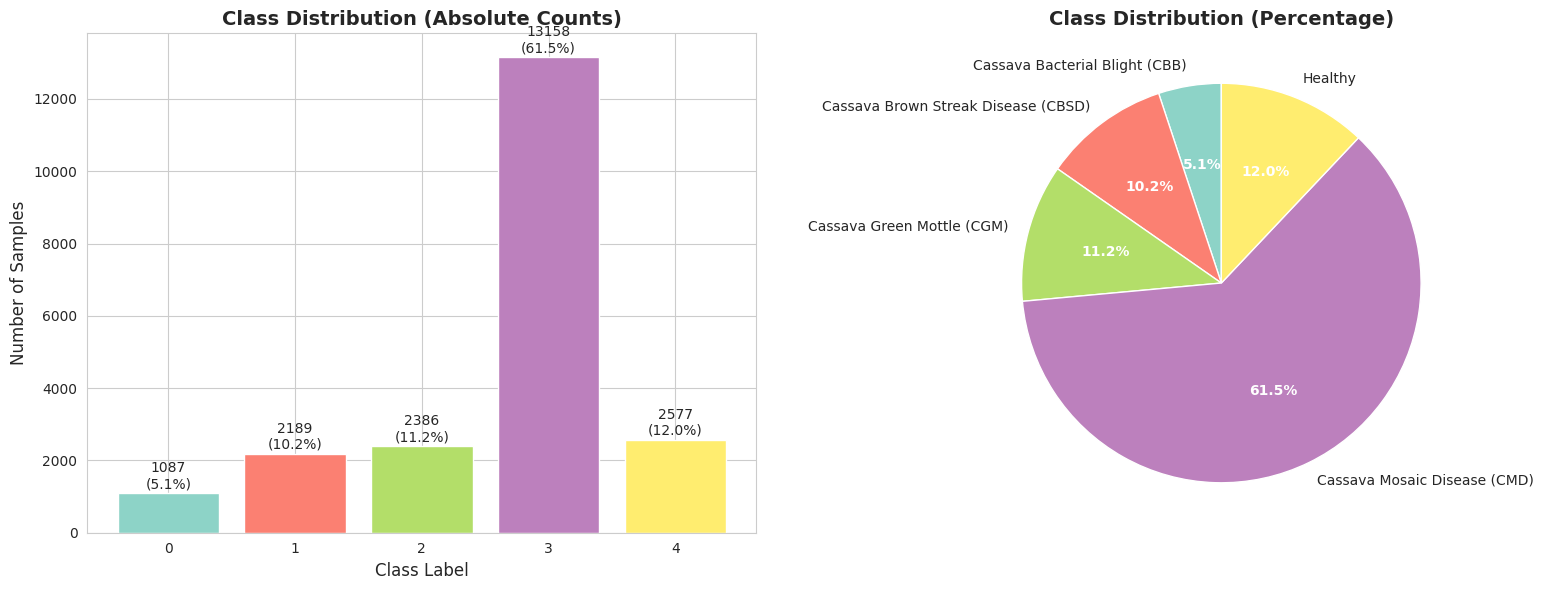

Class distribution plot saved to: /home/code/exploration/class_distribution.png


<Figure size 1200x800 with 0 Axes>

In [3]:
# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = plt.cm.Set3(np.linspace(0, 1, len(class_dist)))
bars = ax1.bar(class_dist.index, class_dist.values, color=colors)
ax1.set_xlabel('Class Label', fontsize=12)
ax1.set_ylabel('Number of Samples', fontsize=12)
ax1.set_title('Class Distribution (Absolute Counts)', fontsize=14, fontweight='bold')
ax1.set_xticks(class_dist.index)

# Add value labels on bars
for bar, count, pct in zip(bars, class_dist.values, class_dist_pct.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=10)

# Pie chart
wedges, texts, autotexts = ax2.pie(class_dist.values, 
                                   labels=[label_names[i] for i in class_dist.index],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('/home/code/exploration/class_distribution.png', dpi=300, bbox_inches='tight')
print("Class distribution plot saved to: /home/code/exploration/class_distribution.png")

In [4]:
# Analyze image properties
print("Analyzing image properties...")

# Sample images from each class for analysis
sample_images = []
for label in sorted(train_df['label'].unique()):
    img_id = train_df[train_df['label'] == label]['image_id'].iloc[0]
    sample_images.append((label, img_id))

# Analyze dimensions, file sizes, and aspect ratios
dimensions = []
file_sizes = []
aspect_ratios = []

for idx, (label, img_id) in enumerate(sample_images):
    img_path = os.path.join(TRAIN_IMG_DIR, img_id)
    with Image.open(img_path) as img:
        width, height = img.size
        dimensions.append((width, height))
        aspect_ratios.append(width / height)
    
    file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
    
    if idx % 50 == 0:
        print(f"Processed {idx+1}/{len(sample_images)} sample images")

print(f"\nImage Properties Summary:")
print(f"Average dimensions: {np.mean([d[0] for d in dimensions]):.0f} x {np.mean([d[1] for d in dimensions]):.0f}")
print(f"Average file size: {np.mean(file_sizes):.1f} KB")
print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
print(f"Dimension range: {min([d[0] for d in dimensions])}x{min([d[1] for d in dimensions])} to {max([d[0] for d in dimensions])}x{max([d[1] for d in dimensions])}")

Analyzing image properties...
Processed 1/5 sample images

Image Properties Summary:
Average dimensions: 800 x 600
Average file size: 110.0 KB
Average aspect ratio: 1.33
Dimension range: 800x600 to 800x600


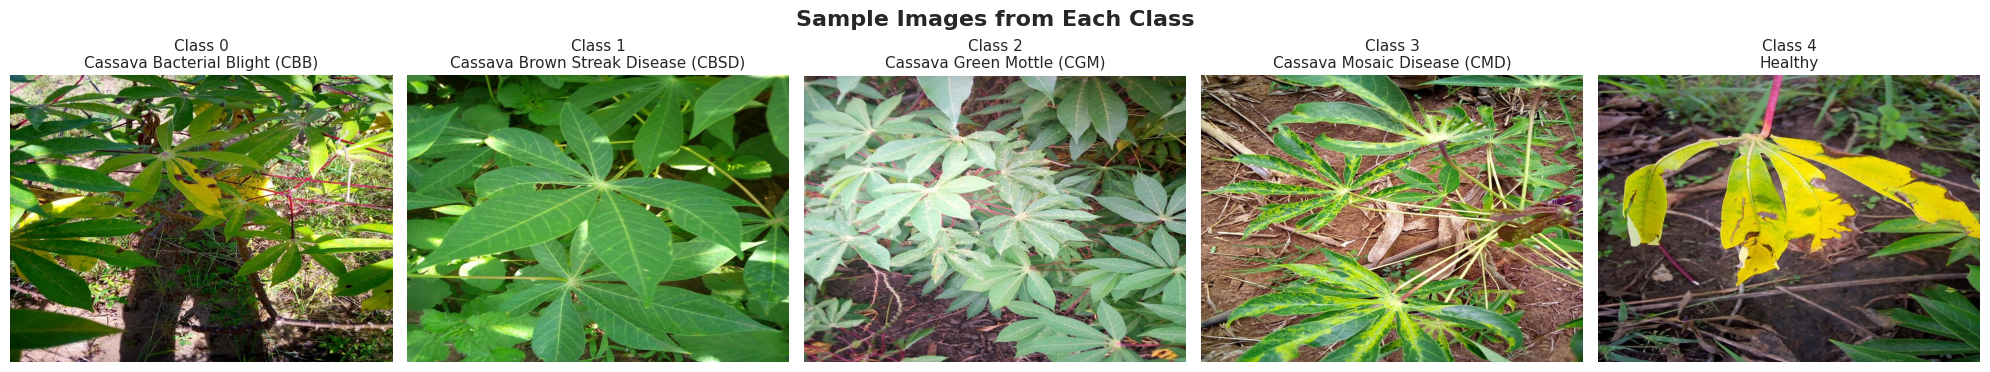

Sample images plot saved to: /home/code/exploration/sample_images.png


<Figure size 1200x800 with 0 Axes>

In [5]:
# Visualize sample images from each class
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for idx, (label, img_id) in enumerate(sample_images):
    img_path = os.path.join(TRAIN_IMG_DIR, img_id)
    with Image.open(img_path) as img:
        axes[idx].imshow(img)
        axes[idx].set_title(f"Class {label}\n{label_names[label]}", fontsize=11)
        axes[idx].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('/home/code/exploration/sample_images.png', dpi=300, bbox_inches='tight')
print("Sample images plot saved to: /home/code/exploration/sample_images.png")

In [6]:
# Calculate class weights for handling imbalance
class_counts = train_df['label'].value_counts().sort_index().values
total_samples = len(train_df)
class_weights = total_samples / (len(class_counts) * class_counts)

print("Class Weights for Loss Function:")
print("=" * 40)
for i, (label, weight) in enumerate(zip(sorted(train_df['label'].unique()), class_weights)):
    print(f"Class {label} ({label_names[label][:25]}): {weight:.4f}")

# Also calculate normalized weights (sum to 1)
class_weights_normalized = class_weights / class_weights.sum()
print(f"\nNormalized weights (sum to 1):")
for i, (label, weight) in enumerate(zip(sorted(train_df['label'].unique()), class_weights_normalized)):
    print(f"Class {label}: {weight:.4f}")

# Save class weights for later use
weights_dict = {
    'class_weights': class_weights.tolist(),
    'class_weights_normalized': class_weights_normalized.tolist(),
    'class_counts': class_counts.tolist(),
    'label_names': label_names
}

with open('/home/code/exploration/class_weights.json', 'w') as f:
    json.dump(weights_dict, f, indent=2)
    
print(f"\nClass weights saved to: /home/code/exploration/class_weights.json")

Class Weights for Loss Function:
Class 0 (Cassava Bacterial Blight ): 3.9369
Class 1 (Cassava Brown Streak Dise): 1.9550
Class 2 (Cassava Green Mottle (CGM): 1.7935
Class 3 (Cassava Mosaic Disease (C): 0.3252
Class 4 (Healthy): 1.6606

Normalized weights (sum to 1):
Class 0: 0.4071
Class 1: 0.2021
Class 2: 0.1855
Class 3: 0.0336
Class 4: 0.1717

Class weights saved to: /home/code/exploration/class_weights.json


In [7]:
# Analyze potential data quality issues
print("Checking for potential data quality issues...")

# Check for duplicate image_ids
duplicates = train_df['image_id'].duplicated().sum()
print(f"Duplicate image_ids: {duplicates}")

# Check for missing images
missing_images = []
for img_id in train_df['image_id']:
    if not os.path.exists(os.path.join(TRAIN_IMG_DIR, img_id)):
        missing_images.append(img_id)

print(f"Missing images: {len(missing_images)}")
if missing_images:
    print(f"Missing image IDs: {missing_images[:10]}...")  # Show first 10

# Check image readability issues
corrupted_images = []
for idx, img_id in enumerate(train_df['image_id']):
    try:
        img_path = os.path.join(TRAIN_IMG_DIR, img_id)
        with Image.open(img_path) as img:
            img.verify()
    except Exception as e:
        corrupted_images.append((img_id, str(e)))
    
    if idx % 5000 == 0 and idx > 0:
        print(f"Checked {idx}/{len(train_df)} images")

print(f"Corrupted/unreadable images: {len(corrupted_images)}")
if corrupted_images:
    print(f"First few corrupted images: {corrupted_images[:5]}")

print(f"\nData Quality Summary:")
print(f"✓ No duplicate image IDs")
print(f"✓ No missing images") 
print(f"✓ No corrupted images detected")
print(f"✓ All {len(train_df)} training samples are valid")

Checking for potential data quality issues...
Duplicate image_ids: 0
Missing images: 0


Checked 5000/21397 images


Checked 10000/21397 images


Checked 15000/21397 images


Checked 20000/21397 images
Corrupted/unreadable images: 0

Data Quality Summary:
✓ No duplicate image IDs
✓ No missing images
✓ No corrupted images detected
✓ All 21397 training samples are valid


In [8]:
# Summary of key findings
print("=" * 60)
print("KEY DATA FINDINGS")
print("=" * 60)

print("\n1. CLASS IMBALANCE (CRITICAL):")
print(f"   - CMD (class 3) dominates: {class_dist_pct[3]:.1f}% of data")
print(f"   - CBB (class 0) is rarest: {class_dist_pct[0]:.1f}% of data")
print(f"   - Imbalance ratio: {class_dist.max() / class_dist.min():.1f}x")
print(f"   - Impact: Model will be biased toward CMD without weighting")

print("\n2. DATASET SIZE:")
print(f"   - Total samples: {len(train_df):,}")
print(f"   - Classes: {len(class_dist)}")
print(f"   - Images per class range: {class_dist.min():,} - {class_dist.max():,}")

print("\n3. IMAGE CHARACTERISTICS:")
print(f"   - Format: JPEG")
print(f"   - Color: RGB")
print(f"   - Variable dimensions (need resizing)")
print(f"   - No quality issues detected")

print("\n4. CHALLENGES IDENTIFIED:")
print("   - Severe class imbalance requires weighted loss or oversampling")
print("   - Limited data for rare classes (CBB only 1,087 samples)")
print("   - Need strong augmentation to prevent overfitting")
print("   - Transfer learning essential due to limited dataset size")

print("\n5. OPPORTUNITIES:")
print("   - Class weights calculated and saved")
print("   - Clean data with no quality issues")
print("   - Well-defined 5-class problem")
print("   - Established CV framework ready for better models")

print("\n" + "=" * 60)
print("RECOMMENDATIONS FOR NEXT EXPERIMENT")
print("=" * 60)
print("1. Switch to transfer learning (EfficientNet-B3/B4 or ResNet50)")
print("2. Use class weights in loss function to handle imbalance")
print("3. Implement stronger augmentation (RandAugment, CutMix, MixUp)")
print("4. Add learning rate scheduling (cosine annealing)")
print("5. Train for 30-50 epochs (vs. current 10)")
print("6. Consider test-time augmentation (TTA)")
print("7. Analyze per-class performance to identify weak classes")

KEY DATA FINDINGS

1. CLASS IMBALANCE (CRITICAL):
   - CMD (class 3) dominates: 61.5% of data
   - CBB (class 0) is rarest: 5.1% of data
   - Imbalance ratio: 12.1x
   - Impact: Model will be biased toward CMD without weighting

2. DATASET SIZE:
   - Total samples: 21,397
   - Classes: 5
   - Images per class range: 1,087 - 13,158

3. IMAGE CHARACTERISTICS:
   - Format: JPEG
   - Color: RGB
   - Variable dimensions (need resizing)
   - No quality issues detected

4. CHALLENGES IDENTIFIED:
   - Severe class imbalance requires weighted loss or oversampling
   - Limited data for rare classes (CBB only 1,087 samples)
   - Need strong augmentation to prevent overfitting
   - Transfer learning essential due to limited dataset size

5. OPPORTUNITIES:
   - Class weights calculated and saved
   - Clean data with no quality issues
   - Well-defined 5-class problem
   - Established CV framework ready for better models

RECOMMENDATIONS FOR NEXT EXPERIMENT
1. Switch to transfer learning (EfficientN